In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import os

## **0 数据预处理**

### **0.1 文件读取和拼接**

In [2]:
# 转换获得标准时间
def fetch_time(timeindex : str):
    t = timeindex.split(" - ")[0]
    days,hour = t.split(" ")
    day,month,year = days.split(".")
    return year + "-" + month + "-" + day + " " + hour

**将每年的数据文件读取，并完成三件事：**
* 将15分钟频率数据利用窗口均值转换为小时频率数据
* 从数据中获取每个小时的时间索引
* 将2015-01-01至2022-04-30的数据进行拼接

In [3]:
# 数据预处理
alldata = []
for file in os.listdir("ENTSO-E/"):
    if file != "Preprocessed data.csv":
        data = pd.read_csv("ENTSO-E/%s"%(file))
        data.dropna(axis=0,inplace=True)
        data["group"] = data["Time (CET/CEST)"].apply(lambda x : str(x).split(" - ")[0][0:13])
        TimeIndex = data.groupby(by="group").first()["Time (CET/CEST)"]
        Values = data.groupby(by="group").mean()
        merge = pd.concat([TimeIndex,Values],axis=1)
        merge["Time (CET/CEST)"] = pd.to_datetime(merge["Time (CET/CEST)"].apply(fetch_time))
        merge.sort_values(by="Time (CET/CEST)",inplace=True)
        alldata.append(merge.copy())

In [4]:
# 拼接数据，保存文件
df = pd.concat(alldata,axis=0,ignore_index=True)
df.to_csv("ENTSO-E/Preprocessed data.csv",index=False)
df["hour"] = df["Time (CET/CEST)"].apply(lambda x : int(str(x).split(" ")[1][0:2]) + 1)
df.columns = ["time","forcast","true","hour"]
df["error"] = df["true"] - df["forcast"]

处理掉一些异常值，保证每天都有24小时

In [5]:
alltime = df["time"].apply(lambda x :  str(x).split(" ")[0]).unique()
df["days"] = df["time"].apply(lambda x :  str(x).split(" ")[0])
for day in tqdm(alltime):
    count = len(df[df["days"] == day])
    if count != 24:
        df.drop(df[df["days"] == day].index,inplace=True)
df.sort_values(by="time",inplace=True)
df.reset_index(inplace=True,drop=True)

100%|██████████| 2677/2677 [00:19<00:00, 140.08it/s]


([<matplotlib.axis.XTick at 0x16410225ca0>,
 [Text(0, 0, '2022-01-01\n00:00'),
  Text(24, 0, '2022-01-01\n06:00'),
  Text(48, 0, '2022-01-01\n12:00'),
  Text(72, 0, '2022-01-01\n18:00'),
  Text(96, 0, '2022-01-02\n00:00'),
  Text(120, 0, '2022-01-02\n06:00'),
  Text(144, 0, '2022-01-01\n12:00'),
  Text(168, 0, '2022-01-02\n18:00'),
  Text(192, 0, '2022-01-03\n00:00')])

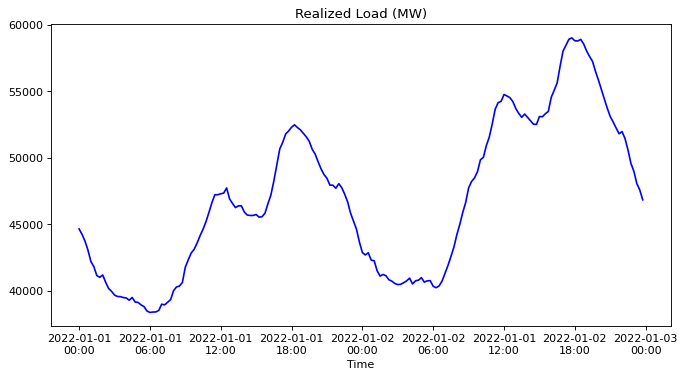

In [21]:
s = data.iloc[0:4*24*2,2].values
fig = plt.figure(figsize=(10,5),dpi=80)
plt.plot(s,color="blue")
plt.title("Realized Load (MW)")
plt.xlabel("Time")
plt.xticks(ticks=[0,4*6,4*12,4*18,4*24,4*30,4*36,4*42,4*48],
           labels=["2022-01-01\n00:00","2022-01-01\n06:00","2022-01-01\n12:00","2022-01-01\n18:00","2022-01-02\n00:00",\
                    "2022-01-02\n06:00","2022-01-01\n12:00","2022-01-02\n18:00","2022-01-03\n00:00"])

Text(0.5, 0, 'Time')

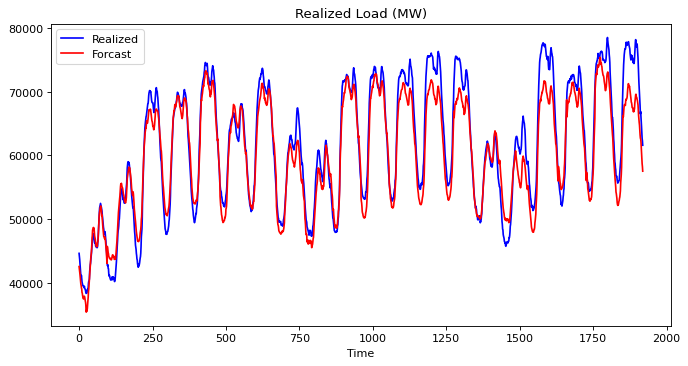

In [9]:
fig = plt.figure(figsize=(10,5),dpi=80)
s = data.iloc[0:40*24*2,2].values
plt.plot(s,color="blue",label="Realized")
s = data.iloc[0:40*24*2,1].values
plt.plot(s,color="red",label="Forcast")
plt.legend()
plt.title("Realized Load (MW)")
plt.xlabel("Time")
# plt.xticks(ticks=[0,4*6,4*12,4*18,4*24,4*30,4*36,4*42,4*48],
#            labels=["2022-01-01\n00:00","2022-01-01\n06:00","2022-01-01\n12:00","2022-01-01\n18:00","2022-01-02\n00:00",\
#                     "2022-01-02\n06:00","2022-01-01\n12:00","2022-01-02\n18:00","2022-01-03\n00:00"])

保存数据

In [6]:
df.to_csv("Preprocessed data.csv")

### **0.2 基础的序列可视化**

In [7]:
# 绘制历史预测的误差图样
def plot_series(df : pd.DataFrame, start : int=0, end : int=365, gap : int=250,
                title : str="Prediction Errors Over Time"):
    fig = plt.figure(figsize=(12,5),dpi=80)
    plt.plot(range(end-start),df.iloc[start:end,2] - df.iloc[start:end,1],color='blue',label="errors")
    plt.xticks(ticks=range(start,end,gap),labels=["%s\n%s"%(str(x)[0:10], str(x)[11:17]) for x in df.iloc[start:end,0][::gap]])
    plt.xlabel("Time")
    plt.ylabel("Prediction Errors")
    plt.title(title)
    plt.legend()

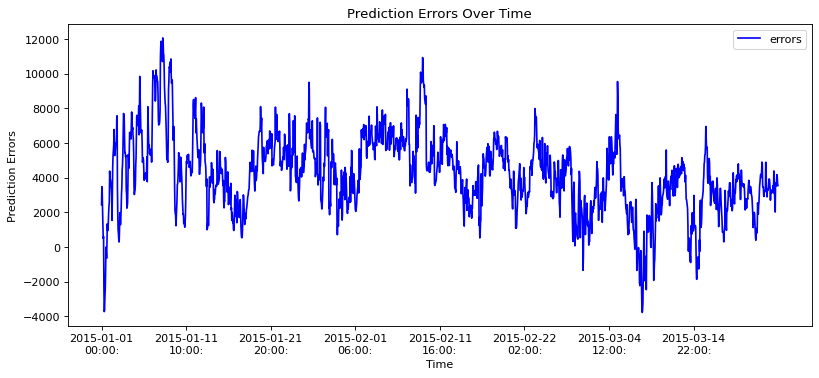

In [8]:
plot_series(df,start=0,end=2000)

## **2 核心算法**

### **2.1 ELP阶段(Error Learning Phase)**

在这一步，**针对任意一种时序预测方法，我们需要根据历史预测误差，为时序预测方法的误差分布建模**，具体地：
* 假设在$(t,h)$时刻，我们待估计的误差模型为$G_{t,h}(x)$
* **历史预测误差$\epsilon_{t,h}$的时序模式将会与所使用的预测方法相关**，如果误差分布近似白噪声，可以假设$y_t | \mathcal{F}_{t-1}$不随时间改变，此时$G_{t,h}(x)=F_h(x)$
* **如果误差时序$\epsilon_{t,h}$展现明显的时序结构**，则我们可以对其假设时序模型（AR,ARMA,ARIMA,SARIMA），去除时序结构项，得到修正后的误差$\overline{\epsilon}_{t,h}$
  * 对修正后的误差，可以进行相应检验（Ljung-Box，Q-Q图，直方图），以确保时序建模方法和参数选择正确
* 修正后的误差可以估计得到历史预测误差的均值和方差$\hat{\mu}_{t,h},\hat{\sigma}_{t,h}^2$
* 考虑标准化后的误差$z_{t,h}$，并对误差分布建模：
$$ z_{t,h} = \frac{\overline{\epsilon}_{t,h} - \hat{\mu}_{t,h}}{\hat{\sigma}_{t,h}} $$
  * 可以考虑参数分布建模，例如假设$z_{t,h}$服从标准正态分布，即$G_{t,h}(x) = \Phi(x)$
  * 可以考虑非参数经验分布建模，使用累计经验分布函数近似，下面$n$代表序列长度：
$$ G_{t,h}(x) = \frac{1}{n}\sum_{i=1}^{n}{ \mathbf{I}(z_{t,h}\leq x ) } $$

----

绘制观察每个小时的误差时序图样（下图2015-2016年的每天第一个小时为例），可以**观察到明显的季节性，因此可以考虑SARIMA模型.**

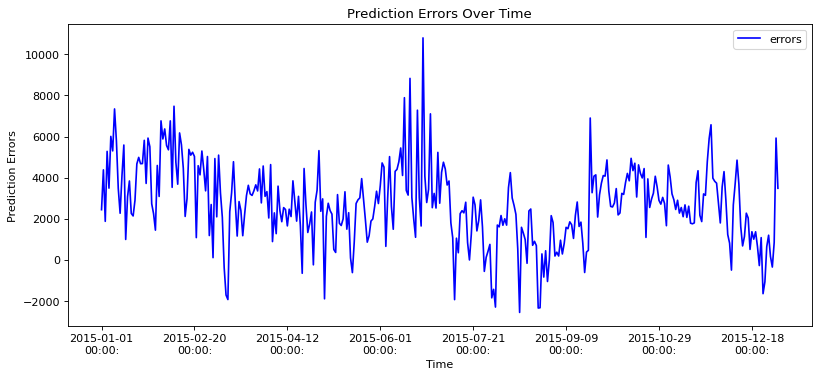

In [9]:
plot_series(df[df["hour"] == 1],start=0,end=365,gap=50)

使用SARIMAX模块完成相应的时序建模工作.

In [10]:
# 选取相应的误差序列
errors = df[df["hour"] == 1].iloc[0:365,2] - df[df["hour"] == 1].iloc[0:365,1]
# 重设索引
errors.reset_index(inplace=True,drop=True)
# 对误差建模
err_model = SARIMAX(errors, order=(2,1,1), seasonal_order=(1,0,0,7)).fit(disp=0)
# 去除修正后的误差
resid = err_model.resid

**可以考察模型拟合系数的显著性，以及其它检验指标，例如AIC，BIC**

In [11]:
err_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 7)   Log Likelihood               -3195.408
Date:                            Mon, 02 May 2022   AIC                           6400.816
Time:                                    10:34:59   BIC                           6420.302
Sample:                                         0   HQIC                          6408.561
                                            - 365                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3092      0.067      4.630      0.000       0.178       0.440
ar.L2          0.1255      0.070      1.795      0.073      -0.012       0.263
ma.L1         -0.9354      0.031    -29.984      0.000      -0.997      -0.874
ar.S.L7        0.1861      0.052      3.584      0.000       0.084       0.288
sigma2      2.687e+06   1.67e+05     16.122      0.000    2.36e+06    3.01e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                55.77
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**同时，对处理后的误差序列进行正态性的检验，确保其通过正态性检验**

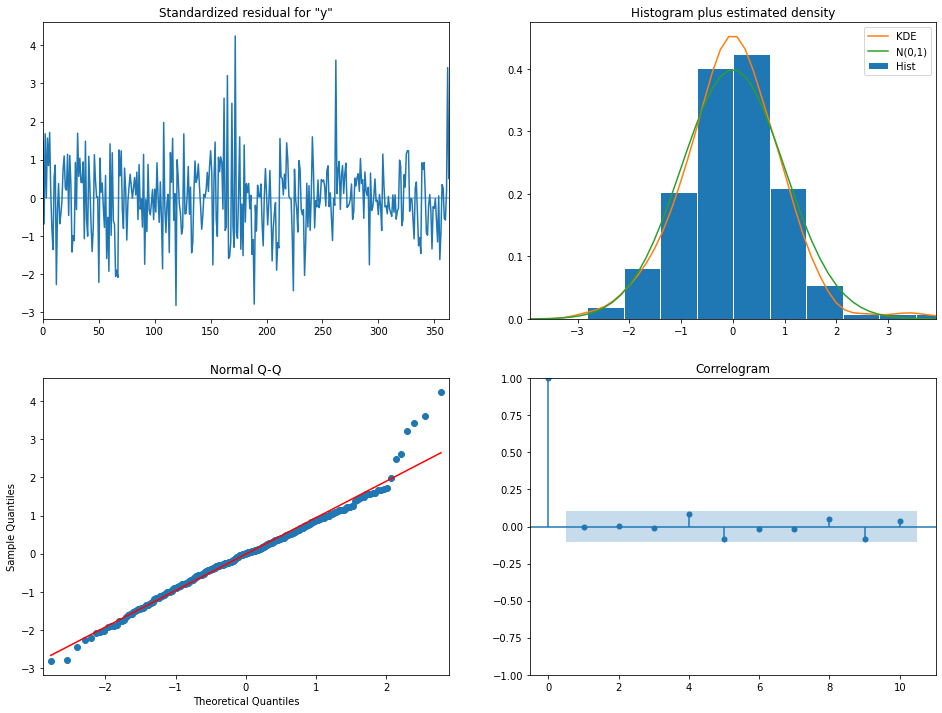

In [12]:
# 利用时序图，直方图，Q-Q图检验
fig = err_model.plot_diagnostics(figsize=(16,12))

In [13]:
# 直接使用Ljung-Box进行白噪声检验
print("Ljung-Box白噪声检验p-value: \n",acorr_ljungbox(err_model.resid,lags=6)["lb_pvalue"])

Ljung-Box白噪声检验p-value: 
 1    0.902622
2    0.992522
3    0.999365
4    0.598821
5    0.444452
6    0.565426
Name: lb_pvalue, dtype: float64


可以看到，所有p值均显著大于0.05，我们无法不拒绝白噪声检验的原假设，接受原假设，认为修正后的误差分布是一个白噪声序列

----

最后，我们把所有的功能和模块进行封装，便于后续调用

In [47]:
# 用于构建误差分布的类
class error_distribution:
    """
    历史预测误差的分布函数
    ----------
    error_distribution(self, mu : float, sigma : float, errors : pd.Series, parametric : bool=True)
        提供时序建模后的误差序列，及其均值，标准差，以及分布建模方法（参数或非参数），得到误差分布

    Parameters
    ----------
    mu : float
        历史误差均值
    sigma : float
        历史误差标准差
    errors : pd.Series | np.ndarray
        标准化后的历史误差时间序列
    parametric : bool, optional
        分布建模方式，`True`使用参数模型（标准正态）\n
        `False`使用非参数的经验分布函数进行估计，默认值为`True`
    """
    def __init__(self, mu : float, sigma : float, errors : pd.Series, parametric : bool=True) -> None:
        self.mu = mu
        self.sigma = sigma
        self._errors = errors.values
        self.parametric = parametric
        # 如果使用参数模型
        if parametric:
            self._G_th = norm.cdf
            self._inv_G_th = norm.ppf
        # 使用非参数模型
        else:
            self._G_th = lambda x : np.sum(self._errors <= x, axis=1) / len(self._errors)
            self._inv_G_th = lambda x : np.quantile(self._errors, x)
    
    def __call__(self, x : np.ndarray, mode : str='cdf') -> np.ndarray:
        """
        __call__(self, x, mode : str='cdf') -> np.ndarray
            利用拟合得到的误差分布计算相应得概率或分位数
        
        Parameters
        ----------
        x : np.ndarray
            输入得自变量，当`mode = 'cdf'`时，`x`表示分布值，取值实数\n
            当`mode = 'inv'`时，`x`表示分位数，取值[0,1]
        mode : str, optional
            决定是计算累积分布概率还是计算分位数，可选`['cdf', 'inv']`\n
            默认值`cdf`，即计算累积分布函数得值，若为`inv`，则返回误差分布得x-分位数
        """
        if not isinstance(x, np.ndarray):
            x = np.array(x)
        if not self.parametric and mode == 'cdf':
            x = x.reshape(-1,1)
        if mode == "cdf":
            return self._G_th((x - self.mu) / self.sigma)
        if mode == "inv":
            return self._inv_G_th(x)

def error_learning_phase(errors : pd.Series, order : tuple=(2,1,1), seasonal_order : tuple=(1,0,0,7),
                         alpha : float=0.05, parametric : bool=True, m2 : int=90, mode : str='SARIMA',
                         check_norm : bool=True, verbose : bool=False) -> error_distribution:
    """
    error_learning_phase
        历史预测误差分布拟合的ELP阶段，使用SARIMA对误差时序建模
    
    Parameters
    ----------
    errors : pd.Series | np.ndarray
        每个小时的误差时间序列
    order : tuple, optional
        SARIMA模型中的ARMA阶数，默认值`(p,d,q) = (2,1,1)`
    seasonal_order : tuple, optional
        SARIMA模型中的季节项ARMA阶数，默认值`(P,D,Q,s) = (1,0,0,7)`
    alpha : float, optional
        Ljung-Box检验的显著性水平，默认值`0.05`
    parametric : bool, optional
        对误差分布的建模方式，`True`表示使用参数模型，假设误差分布为标准正态分布\n
        `False`表示使用非参数模型，将使用经验分布函数获得分布函数\n
        默认值为`True`
    m2 : int, optional
        用于误差分布推断时所使用的样本量，默认值为`90`，其必须小于`errors`的长度
    mode : str, optional
        选择是否对误差时序建模，默认值`SARIMA`，可以设置为`naive`，则不进行时序建模
    check_norm : bool, optional
        是否对时序建模过滤后的误差进行Ljung-Box正态性检验，默认值为`True`
    verbose : bool, optional
        是否打印提醒信息，默认值`False`
    
    Return
    ----------
    G_{t,h} : error_distribution
        返回拟合得到的历史预测误差的分布
    """
    if mode == "SARIMA":
        # 拟合时序模型
        # 尝试进行SARIMAX建模，如果建模失败，则不进行时序建模
        try:
            err_model = SARIMAX(errors, order=order, seasonal_order=seasonal_order).fit(disp=0)
        except:
            return error_learning_phase(errors=errors, parametric=False, m2=m2, mode='naive')
        # 过滤后的误差数据
        resid = err_model.resid
        # 检验正态性
        if check_norm:
            ljung_box_pvalue = acorr_ljungbox(resid,lags=6)["lb_pvalue"]
            for p in ljung_box_pvalue:
                if p < alpha and verbose:
                    print("注意时序模型得到的误差序列无法通过Ljung-Box白噪声检验，请检查时序模型")
        # 计算均值和方差
        mu = np.mean(errors - resid)
        sigma = np.std(resid)
    elif mode == "naive":
        # 直接使用原始的误差时序
        resid = errors
        # raw errors假设均值为0，方差为1
        mu = 0
        sigma = 1
    # 得到修正后的误差，选取最后的m2个样本，用于推断误差分布
    if m2 > len(errors):
        m2 = len(errors)
    # 估计误差的分布
    standard_z = (errors[-m2:] - mu) / sigma
    # 使用参数模型确认分布
    return error_distribution(mu=mu,sigma=sigma,errors=standard_z,parametric=parametric)

### **2.2 DLP阶段(Dependence Learning Phase)**

在这一步，我们需要**利用ELP学习得到的每个小时的误差边际分布，利用copula连接函数，对它们的相依性关系建模，从而得到多元联合分布**
* DLP的核心是**获得$\epsilon_{t,h},h=1,2,\cdots,24$的联合分布，所使用的方法是copula函数**
* Sklar定理指出，对于ELP阶段我们得到的24个分布$G_{t,1},\cdots,G_{t,24}$，存在copula函数$C:[0,1]^{24}\to [0,1]$，使得联合分布$G_{\epsilon_t}$有：
  $$ G_{\epsilon_t}(\theta) = C(G_{t,1}(\theta_1),\cdots,G_{t,24}(\theta_{24})) $$
  * 例如在独立性场合，copula函数为各个元素的乘积：
  $$ G_{\epsilon_t}(\theta) = C(G_{t,1}(\theta_1),\cdots,G_{t,24}(\theta_{24})) = \prod_{i=1}^{24} G_{t,i}(\theta_i) $$
  * 可以考虑参数copula，例如Gauss copula函数，设**联合分布为均值为0的多元正态分布$\Phi_{\Sigma}$，核心在于估计分布的协方差矩阵$\Sigma$**，其具有$(24\times 23)/2=276$个自由变量，足够去捕获复杂的相依性特征. 估计Gauss copula需要使用秩相关性估计器. 此时，联合概率表示为：
  $$ G_{\epsilon_t}(\theta) = C(G_{t,1}(\theta_1),\cdots,G_{t,24}(\theta_{24})) = \boldsymbol{\Phi}_{\Sigma}(\Phi^{-1}(G_{t,1}(\theta_1)),\cdots,\Phi^{-1}(G_{t,24}(\theta_24))) $$
  * 可以考虑非参数copula，即经验copula. 此时，我们无需假定copula函数$C$的具体形式.
    * 对于每个小时$h$，考虑一个包含过去$m$天的样本：
    $$ \{ (\epsilon_{t,1},\cdots,\epsilon_{t,24}),t=1,2,\cdots,m \} $$
    * 考虑这些样本对应误差分布的分位数
    $$ u_{t,h} = G_{t,h}(\epsilon_{t,h}) \in [0,1] $$
    * 为了记号简单考虑，假设这$m\times 24$个样本没有重复值，下面对每个小时$h=1,2,\cdots,24$，为$u_{t,h}$分配其在$u_{1,h},\cdots,u_{m,h}$的排序$\text{rk}(u_{t,h})$
      * 因此，对每个$h$，最小的分位点将会分配到$\text{rk}(u_{t,h})=1$，而最大的分位点将会分配到$\text{rk}(u_{t,h}) = m$.
      * 基于此长度为$m$的样本的经验copula函数表达为：
      $$
      \mathbb{E}_{T}(i_1/m,\cdots,i_{24}/m) = \frac{1}{m} \sum_{t=1}^{m} \mathbf{I}\{ \text{rk}(u_{t,1})\leq i_1,\cdots,\text{rk}(u_{t,24})\leq i_{24} \}
      $$
      * 上式中，$0\leq i_1,\cdots,i_{24}\leq m$全为整数，当其全为0时，copula函数等于0，当其全为$m$时，copula函数等于1.

----

出于简单考虑，这里我们仅实现经验copula函数

In [15]:
# 经验copula
class empirical_copula:
    """
    非参数经验copula函数
    ----------
    empirical_copula(self, rank : np.ndarray)
        用秩矩阵和历史误差分布构造经验copula函数

    Parameters
    ----------
    rank : np.ndarray
        在DLP阶段利用历史误差分布计算得到的秩矩阵，维度(`m` * 'H')，在该实验中，`H` = 24代表24个小时
    """
    def __init__(self, rank : np.ndarray):
        # 排序矩阵
        self._rank = rank.astype('int')
        # 样本量
        self.m = len(rank)
        self.p = len(rank[0])

    def __call__(self, x : np.ndarray):
        # 检测输入维度
        try:
            assert(len(x) == self.p)
        except:
            raise ValueError("自变量维度 %d 不符合copula的特征维度 `p = %d`"%(len(x),self.p))
        # 计算经验copula
        return (self._rank <= x).all(axis=1).sum() / self.m

def dependence_learning_phase(errors : pd.DataFrame, G_th : list[error_distribution]) ->  empirical_copula:
    """
    dependence_learning_phase
        使用copula技术构造联合分布的的DLP阶段，使用经验copula函数
    
    Parameters
    ----------
    errors : pd.DataFrame
        历史预测误差样本，维度为(`m` * `H`)，在该实验中，`H` = 24代表24个小时
    G_th : list[error_distribution]
        历史预测误差的分布集合，由ELP阶段学习得到\n
        每个元素代表各个小时的误差分布，因此需要确保`len(G_th) == H`
    
    Return
    ----------
    copula : empirical_copula
        返回学习得到的经验copula函数
    """
    # 判断维度是否相等
    try:
        assert(errors.shape[1] == len(G_th))
    except:
        raise ValueError("历史误差序列与提供的误差分布维度不匹配，`errors`包含%d个误差序列，而`G_th`提供了%d个误差分布"%(errors.shape[1],len(G_th)))
    # 计算分位数点
    quantile = errors.values
    # 排名
    rank = errors.values.copy()
    for i,G in enumerate(G_th):
        quantile[:,i] = G(errors.iloc[:,i])
        rank[np.argsort(quantile[:,i]),i] = np.arange(len(rank)) + 1
    copula = empirical_copula(rank=rank)
    return copula

----

观察一下每天24小时用电负载的相依性结构和极值聚集现象

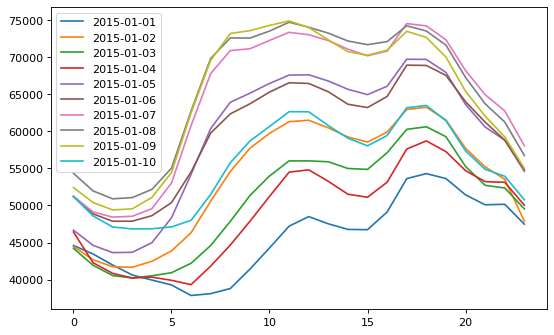

In [52]:
fig = plt.figure(figsize=(8,5),dpi=80)
samples = df["days"].unique()[0:10]
for day in samples:
    plt.plot(df[df["days"] == day]["true"].values,label=day)
plt.legend()

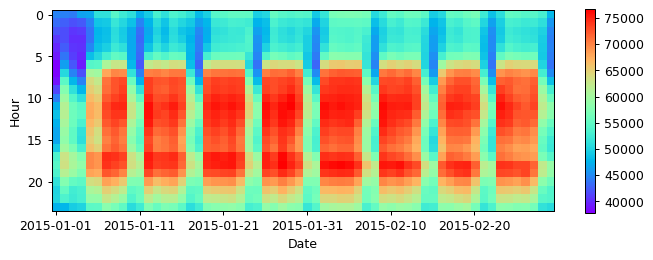

In [66]:
samples = df.iloc[0:60*24,2].values.reshape(60,24)
date = df["days"].unique()[0:60][::10]
fig = plt.figure(figsize=(9,3),dpi=90)
plt.imshow(samples.T,cmap=plt.cm.rainbow)
plt.ylabel("Hour")
plt.xlabel("Date")
plt.xticks(ticks=range(0,60,10),labels=date)
plt.colorbar()

下面对**DLP相依性学习阶段**的算法进行实验

首先，选择2015-01-01至2016-01-01年的数据，用于拟合预测误差的边际分布$G_{t,h}$

In [16]:
# 拟合预测误差的分布
G_th = []
for h in range(1,25):
    error = df[df["hour"] == h].iloc[0:365,2] - df[df["hour"] == h].iloc[0:365,1]
    G_th.append(error_learning_phase(errors=error,parametric=False))

接下来，利用误差分布，选择2016年前3月的数据，估计得到经验copula函数

In [17]:
start = 365
m = 90 # 窗口长度90天，即取前三个月
hist_errors = []
for h in range(1,25):
    error = df[df["hour"] == h].iloc[start:start+m,2] - df[df["hour"] == h].iloc[start:start+m,1]
    error.reset_index(drop=True,inplace=True)
    hist_errors.append(error)
hist_errors = pd.concat(hist_errors,axis=1,ignore_index=True)
# 估计经验copula函数
copula = dependence_learning_phase(hist_errors,G_th)

来测试copula函数对于联合分布概率的估计

In [18]:
x = np.random.randint(45,m,24)
print("x: ",x)
print("copula: ",copula(x))

x:  [49 51 45 58 81 70 87 86 88 61 67 77 76 46 45 60 50 51 66 86 62 65 46 84]
copula:  0.24444444444444444


### **2.3 FP阶段(Forcast Phase)**

加下来，我们需要**结合ELP和DLP两个阶段得到的误差分布和copula函数，来构造多变量预测的概率分布**
* 首先，我们构造一个样本量为$m$的多变量概率估计，对下一天的每个小时$h$，有：
  $$
  \hat{y}_{t,h}^i = \left( \hat{y}_{t,h} + \mu_{t,h} \right) + G_{t,h}^{-1}\left( \frac{i}{m+1} \right)\times \sigma_{t,h},\quad i=1,2,\cdots,m
  $$
  $G_{t,h}^{-1}$是估计得到的误差分布的逆（即分位数函数），$\mu_{t,h},\sigma_{t,h}$是拟合误差分布时得到的相应的分布参数
* **如果ELP阶段没有对误差分布建立时序模型**，则假设误差分布服从标准正态分布，且在上式中$\mu_{t,h}\equiv 0,\sigma_{t,h}\equiv 1$
* 到目前为止，我们基于误差分布获得了各个小时的边际分布的概率预测，现在要**通过DLP阶段的copula函数使这些独立的预测具备正确的相依性**
* 为了实现上述目的，我们需要得到copula函数的一个离散表达，我们用一个秩矩阵$R$表示
  * **对于参数copula**，例如Gauss copula，我们从拟合的参数copula模型中，从大小为$m$的随机样本中导出秩矩阵，即在学习得到的copula上，为$m$个随机样本的每一个小时维度$h$分配排名，最小值从1开始标号
  * **对于非参数copula**，即经验copula，秩矩阵$R$在点估计的经验copula计算中已经计算得到，即**DLP阶段中计算的排序矩阵**
* **根据秩矩阵$R$对每小时的单变量集合预测进行排序，以使得多元变量概率预测采用copula给出的依赖结构**

----

**在DLP阶段我们使用经验copula函数为FP阶段的预测带来了极大便利**

In [27]:
def forcast_phase(y_hat : pd.Series, G_th : list[error_distribution], copula : empirical_copula,
                  independent : bool=False) -> pd.DataFrame:
    """
    forcast_phase(y_hat : pd.Series) -> pd.DataFrame
        结合ELP和DLP进行多变量概率预测
    
    Paramaters
    ----------
    y_hat : pd.Series | np.ndarray
        对下一天各时段的点预测，维度为`H`，在该实验中，`H` = 24代表24个小时
    G_th : list[error_distribution]
        ELP阶段拟合得到的各个小时的误差分布，维度为`H`，在该实验中，`H` = 24代表24个小时
    copula : empirical_copula
        DLP阶段学习得到的copula函数
    independent : bool, optional
        各个小时之间预测的相依性假设，可选`[True, False]`\n
        `True`表示假设各个小时之间的预测独立，概率预测仅使用误差的边际分布构造\n
        `False`表示各个小时之间的预测有相依性，依靠`copula`提供的相依性构造多元联合分布\n
        默认值为`False`，即考虑所给`copula`提供的序列间相依性
    
    Return
    ----------
    prob_forcast : np.ndarray
        对多变量的概率预测，维度(`m` * `H`)，在该实验中，`H` = 24代表24个小时
    """
    # 维度检验
    try:
        assert(len(y_hat) == len(G_th) and len(y_hat) == copula.p)
    except:
        raise ValueError("请确保`len(y_hat) = %d`，`len(G_th) = %d`和`copula.p = %d`的维度一致"%(len(y_hat),len(G_th),copula.p))
    if isinstance(y_hat, pd.Series):
        y_hat = y_hat.values
    # 预测的样本数量
    m = copula.m
    p = copula.p
    # 先构造各个小时的概率预测
    prob_forcast = np.zeros((m,p))
    for i in range(p):
        prob_forcast[:,i] = (y_hat[i] + G_th[i].mu) +  (G_th[i](x = np.arange(1,m+1) / (m+1), mode='inv') * G_th[i].sigma) 
        # 如果放弃独立性假设，利用copula的秩矩阵重新排列预测
        if not independent:
            prob_forcast[:,i] = prob_forcast[:,i][copula._rank[:,i] - 1]
    return prob_forcast

----

下面对**FP预测阶段**的算法进行实验

取2016-04-01当天的预测结果

In [20]:
y_hat = df[(df["time"] >= "2016-04-01") & (df["time"] < "2016-04-02")].iloc[:,1]

利用**ELP和DLP阶段学习得到的误差分布和copula函数进行多变量概率预测**，分别考察两种情况：
* 独立性假设下的概率分布预测
* 相依性假设下的概率分布假设

首先考察独立性假设下的概率预测

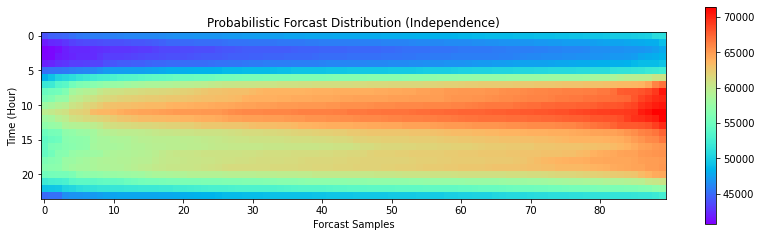

In [21]:
# 进行多变量条件预测
y_hat_prob = forcast_phase(y_hat.values,G_th,copula,independent=True)
# 绘制分布图样
fig = plt.figure(figsize=(14,4))
plt.imshow(y_hat_prob.T,cmap=plt.cm.rainbow)
plt.xlabel("Forcast Samples")
plt.ylabel("Time (Hour)")
plt.title("Probabilistic Forcast Distribution (Independence)")
plt.colorbar()

再来考虑相依性假设下，依靠copula得到的多元变量概率预测的结果

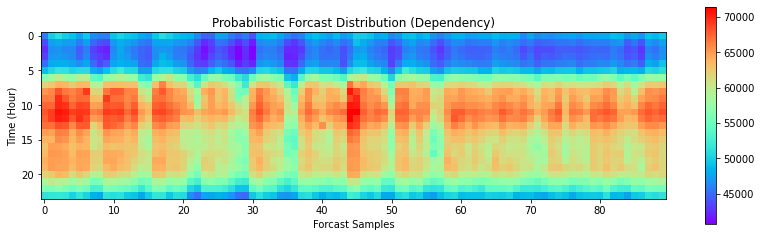

In [22]:
# 进行多变量条件预测
y_hat_prob = forcast_phase(y_hat.values,G_th,copula)
# 绘制分布图样
fig = plt.figure(figsize=(14,4))
plt.imshow(y_hat_prob.T,cmap=plt.cm.rainbow)
plt.xlabel("Forcast Samples")
plt.ylabel("Time (Hour)")
plt.title("Probabilistic Forcast Distribution (Dependency)")
plt.colorbar()

对比上面两图可以看到，**相依性假设下，copula帮助概率预测正确表达了用电负载在一天内的概率分布，极端值连续出现**

## **3 模型评估**

### **3.1 相合性Calibration**

**相合性指，理想情况下，每个观测值都应该是从预测分布中的随机采样**，我们**使用Average Rank Histograms从图像上判断相合性**
* 对于单变量预测（即每个小时预测），使用**verification rank histograms**来评估概率预测的相合性
  * 针对每个小时$h$，考虑未来窗口的第$t$天预测，设预测概率分布$\{ \hat{y}_{t,h}^i,i=1,2,\cdots,m \}$以及真实值$y_{t,h}$
  * 考虑真实值在该概率分布$\{ y_{t,h}^i,i=1,2,\cdots,m \}$中的排序：
    $$ R_{t,h} = 1 + \sum_{i=1}^{m} \mathbf{I}(\hat{y}_{t,h}^i < y_{t,h}) $$
  * **如果对$h$小时的概率分布估计是相合的，那么$\{R_{t,h}\}$的分布应该服从均匀分布**，表明观察到的价格表现为（特定小时）预测分布的随机抽取
  * 如果观察到一个U型分布，则表示观察到的价格通常高于或低于预测分布的预期，这意味着预测分布过于狭窄
* 对于多变量预测的相合性，我们使用**Average Rank Histograms**，它在单变量的基础上，计算各个小时的均值
  $$ \text{AvgRank}_t = \frac{1}{24}\sum_{h=1}^{24} R_{t,h} $$
  与单变量同理，对于一个完美的预测，其分布应该近似均匀分布

In [24]:
def verification_rank_histograms(y_true : np.ndarray, forcast : np.ndarray,show : bool=False, 
                                 title : str="Verification Rank Histograms") -> np.ndarray:
    """
    verification_rank_histograms(y_true : np.ndarray, forcast : np.ndarray) -> np.ndarray
        对于单点预测的排序直方图判断概率预测的相合性
    
    Parameters
    ----------
    y_true : np.ndarray
        未来窗口的真实值，维度`(T,)`，`T`是时间长度
    forcast : np.ndarray
        对未来窗口的概率预测，维度`(m,T)`，`m`表示概率预测分布的样本量
    show : bool, optional
        是否绘制排序分布直方图，默认值`False`
    
    Return
    ----------
    rank : np.ndarray
        真实值在概率预测分布中的排序情况
    """
    rank = 1 + np.sum(forcast < y_true,axis=0)
    if show:
        fig = plt.figure(figsize=(6,4),dpi=80)
        plt.hist(rank,bins=25,color="red",label="Verification Rank")
        plt.xlabel("Rank")
        plt.ylabel("Frequency")
        plt.title(title)
        plt.legend()
    return rank

def average_rank_histograms(ranks : list[np.ndarray], show : bool=False, title : str="Average Rank Histograms") -> np.ndarray:
    """
    average_rank_histograms(ranks : list[np.ndarray], show : bool=False) -> np.ndarray
        多变量概率预测，绘制平均排序直方图，用于考察概率预测相合性
    
    Parameters
    ----------
    ransk : list[np.ndarray]
        各个单变量的verification rank构成的集合，由函数`verification_rank_histograms`计算得到
    show : bool, optional
        是否绘制排序分布直方图，默认值`False`
    
    Return
    ----------
    AvgRank : np.ndarray
        多变量概率预测的平均排序
    """
    AvgRank = np.mean(ranks,axis=0)
    if show:
        fig = plt.figure(figsize=(6,4),dpi=80)
        plt.hist(AvgRank,bins=25,color="red",label="Verification Rank")
        plt.xlabel("Rank")
        plt.ylabel("Frequency")
        plt.title(title)
        plt.legend()
    return AvgRank

### **3.2 敏锐性Sharpness**

**敏锐性要求分布应尽可能集中**，我们使用**CRPS和能量分数ES**分别考察单变量概率预测和多变量概率预测的优度
* CRPS全称Continuous Ranked Probability Score，对于每一个小时$h$的概率预测累积分布$F$，CRPS定义为：
  $$
  \text{CRPS}(F,y) = \int {\left( F(x) - \mathbf{I}(x\geq y) \right)^2} dx = \mathbb{E}_F[|Y-y|] - \frac{1}{2}\mathbb{E}_F[|Y-Y^{'}|]
  $$
  * 其中，$Y,Y^{'}$是服从$F$的独立随机变量
  * 对每一天的每一个小时计算得到CRPS，然后我们将$T\times 24$个分数取平均作为对模型的评估值
* 能量分数Energy Score是对CRPS在多变量概率预测场合的扩展，其定义如下：
  $$
  \text{ES}(F,y) = \mathbb{E}_F[\|Y-y\|] - \frac{1}{2}\mathbb{E}_F[\|Y-Y^{'}\|]
  $$
  * 相比CRPS，这里仅将绝对值换做向量范数
  * 对于有限预测集合$F_{ens} = \{\hat{y}_1,\cdots,\hat{y}_m\}$，ES的计算可以简化如下：
  $$
  \text{ES}(F_{ens},y) = \frac{1}{m} \sum_{k=1}^{m} \|\hat{y}_k - y\| - \frac{1}{2m^2}\sum_{l=1}^{m}\sum_{k=1}^{m} \|\hat{y}_l - \hat{y}_k\|
  $$
  * 最后，我们将每一天的ES取均值作为对模型的评估值
* **以上两个评估系数，值越小，说明模型的概率预测效果越优**

----

在具体到计算这两个指标的时候，由于我们预测的分布$F$是离散形式的，因此函数的输入直接提供我们对分布预测的样本即可

In [25]:
def CRPS(y_true : np.ndarray, forcast : np.ndarray) -> float:
    """
    CRPS(y_true : np.ndarray, forcast : np.ndarray) -> float
        计算单变量预测的CRPS指标，用于衡量概率预测的敏锐性
    
    Parameters
    ----------
    y_true : np.ndarray
        未来窗口的真实值，维度`(T, H)`，`T`是时间长度，`H`是多变量维度，在该实验中，`H = 24`代表24个小时
    forcast : np.ndarray
        对未来窗口的概率预测，维度`(m,T,H)`，`m`表示概率预测分布的样本量
    
    Return
    ----------
    score : float
        模型在未来预测窗口上的CRPS均值分数
    """
    # 特征维度
    p = y_true.shape[1]
    T = y_true.shape[0]
    score = 0
    for h in range(p):
        y_true_h = y_true[:,h] # 维度 (T, )
        forcast_h = forcast[:,:,h] # 维度 (m, T)
        # 使用广播机制加速计算，避免使用循环
        crps =  abs(y_true_h - forcast_h).mean(axis=0) -\
             0.5*abs(np.expand_dims(forcast_h,axis=2) - forcast_h.T).mean(axis=0).mean(axis=1) # 维度 (T, )
        score += np.sum(crps)
    # 计算均值
    score = score / (p*T)
    return score

def ES(y_true : np.ndarray, forcast : np.ndarray) -> float:
    """
    ES(y_true : np.ndarray, forcast : np.ndarray) -> float
        计算多变量预测的能量分数指标ES，用于衡量多变量概率预测的敏锐性
    
    Parameters
    ----------
    y_true : np.ndarray
        未来窗口的真实值，维度`(T, H)`，`T`是时间长度，`H`是多变量维度，在该实验中，`H = 24`代表24个小时
    forcast : np.ndarray
        对未来窗口的概率预测，维度`(m,T,H)`，`m`表示概率预测分布的样本量
    
    Return
    ----------
    score : float
        模型在未来预测窗口上的ES均值分数
    """
    # 特征维度
    p = y_true.shape[1]
    T = y_true.shape[0]
    score = 0
    for t in range(T):
        y_true_t = y_true[t,:] # 维度 (H, )
        forcast_t = forcast[:,t,:] # 维度 (m, H)
        # 使用广播机制加速计算，避免使用循环
        es = np.linalg.norm(y_true_t - forcast_t,axis=1).mean() \
            - 0.5*np.linalg.norm(np.expand_dims(forcast_t,axis=2) - forcast_t.T,axis=1).mean()
        score += es
    # 计算均值
    score = score / T
    return score

## **4 实验**

### **4.1 组合预测流程**

在具体的模型训练和预测过程中，我们**采用滑动窗口**按天更新ELP和DLP阶段学习得到的参数，在下一天的观测得到后，将窗口向后滚动一天
* 假设要对第$t$天的负载量进行预测
* **ELP阶段**：我们先取$t$时刻之前共$m_1=365$天的误差数据$\epsilon_{t,h}$
  * 可以根据$\epsilon_{t,h}$的时序特征选择是否进行时序建模
  * 如果**使用了时序模型，则将时序模型处理后的最近的$m_2=90$天的误差分布**用于误差分布的推断
  * 如果**没有进行时序建模，则直接使用最近的$m_2=90$天的误差分布**用于误差分布的推断
* **DLP阶段**：选取最近的$m_2=90$天的误差分布（**可以是时序模型处理后的，也可以是原始的误差分布**）推断copula函数
* **ELP阶段**：利用前两个阶段得到的信息对$t$时刻进行推断，然后将窗口向后滚动一天，重复上述流程
* **参数$m_1,m_2$是可供选择的超参数，对于每个用例，需要单独解决窗口大小过短或过长之间的权衡**

In [128]:
def multivariate_probabilistic_forcast(data : pd.DataFrame, start : str="2017-01-01", end : str="2018-01-01",
                                       m1 : int=365, m2 : int=90, parametric : bool=False,
                                       ELP  : str="SARIMA", DLP : str="filtered", FP_independent : bool=False, 
                                       show : bool=True, verbose : bool=True):
    """
    Multivariate Probabilistic Forcast
    ----------
    multivariate_probabilistic_forcast(data : pd.DataFrame, start : str, end : str, 
                                       ELP  : str="SARIMA", DLP : str="filtered", FP : str="dependent")
        从单变量点预测到多变量概率预测
    
    Parameters
    ----------
    data : pd.DataFrame
        包含预测值和真实值的时序数据集
    start : str, opitonal
        预测窗口开始时间，默认值`'2017-01-01'`
    end : str, optional
        预测窗口结束时间，默认值`'2018-01-01'`
    m1 : int, optional
        ELP阶段时序建模窗口长度，默认值`365`
    m2 : int, optional
        误差分布推断窗口长度、DLP阶段窗口长度，以及概率预测样本量，默认值`90`
    parametric : bool, optional
        对误差分布的建模方式，`True`表示使用参数模型，假设误差分布为标准正态分布\n
        `False`表示使用非参数模型，将使用经验分布函数获得分布函数\n
        默认值为`False`
    ELP : str, optional
        ELP阶段是否对误差时序建模，可选`['SARIMA', 'naive']`，默认值`SARIMA`
    DLP : str, optional
        DLP阶段推断copula函数时使用的误差时序，可选`['filtered','raw']`，默认值`'filtered'`
    FP_independent : bool, optional
        各个小时之间预测的相依性假设，可选`[True, False]`\n
        `True`表示假设各个小时之间的预测独立，概率预测仅使用误差的边际分布构造\n
        `False`表示各个小时之间的预测有相依性，依靠`copula`提供的相依性构造多元联合分布\n
        默认值为`False`，即考虑所给`copula`提供的序列间相依性
    show : bool, optional
        是否展示排序直方图以及CRPS，ES指标，默认值`True`
    verbose : bool, optional
        是否打印进度信息，默认值`True`
    
    Return
    ----------
    (forcast,y_true,crps,es,(fig1,fig2)) : tuple
        返回一个元组，里面包含5个元素\n
        `forcast`是对未来时序的概率预测，维度`(m, T, H)`\n
        `y_true`是未来时序的真实值，维度`(T, H)`\n
        `crps`和`es`是单变量和多变量的评价指标\n
        `figs`包含两个排序直方图
    """
    # 获取预测区间的所有日期
    days = data[(data["days"] >= start) & (data["days"] <= end)]["days"].unique()
    T = len(days)
    # 预测结果
    forcast = np.zeros((m2,T,24))
    # 真实值
    y_true = np.zeros((T,24))
    if verbose:
        pbar = tqdm(total=len(days),ncols=100)
    for t,day in enumerate(days):
        idx = data[(data["time"] == "%s 00:00:00"%(day))].index[0]

        # ELP阶段
        #########################################################################################
        # 选取ELP窗口
        ELPdata = data.iloc[idx - m1*24:idx].copy()
        # 拟合误差分布的模型
        G_th = []
        for h in range(1,25):
            error = ELPdata[ELPdata["hour"] == h]["error"]
            G_th.append(error_learning_phase(errors=error,parametric=parametric,m2=m2,mode=ELP,check_norm=False))
        
        # DLP阶段
        ##########################################################################################
        # 选择DLP窗口
        hist_errors = []
        for h in range(1,25):
            if DLP == "raw":
                error = data.iloc[idx - m2*24:idx].copy()
                error = error.loc[error["hour"] == h,"error"]
                error.reset_index(drop=True,inplace=True)
            elif DLP == "filtered":
                error = pd.Series(G_th[h-1]._errors * G_th[h-1].sigma + G_th[h-1].mu)
            hist_errors.append(error)
        hist_errors = pd.concat(hist_errors,axis=1,ignore_index=True)
        # 估计经验copula函数
        copula = dependence_learning_phase(hist_errors,G_th)

        # FP阶段
        ##########################################################################################
        # 从数据中抽取估计值
        y_hat = data.loc[data["days"] == day,"forcast"].values
        # 完成概率分布的预测
        forcast[:,t,:] = forcast_phase(y_hat,G_th,copula,independent=FP_independent)
        # 取出真实值
        y_true[t,:] = data.loc[data["days"] == day,"true"].values
        # 显示进度信息
        if verbose:
            pbar.set_description("Prediction for date: %s"%(day))
            pbar.update(1)
    if verbose:
        pbar.close()
    
    # 模型评估
    ##############################################################################################
    # 计算单点预测的排序直方图
    ranks = []
    # 统计分位数
    quantle = []
    for h in range(24):
        ranks.append(verification_rank_histograms(y_true=y_true[:,h],forcast=forcast[:,:,h]))
        quantle.append(ranks[h] / (m2 + 1))
    # 多变量预测的平均直方图
    AvgRank = average_rank_histograms(ranks=ranks)
    # 计算CRPS
    crps = CRPS(y_true=y_true,forcast=forcast)
    # 计算能量分数ES
    es = ES(y_true=y_true,forcast=forcast)
    fig1, fig2 = None, None
    if show:
        fig1,ax = plt.subplots(24,24,figsize=(24,24),dpi=90)
        ax = ax.flatten()
        cnt = 0
        for i in range(24):
            for j in range(24):
                ax[cnt].set_xticks([])
                ax[cnt].set_yticks([])
                if i == j:
                    ax[cnt].hist(ranks[i],bins=10,color='red')
                else:
                    ax[cnt].scatter(quantle[i],quantle[j],s=2,color='red')
                cnt += 1
        fig2 = plt.figure(figsize=(6,5),dpi=90)
        plt.hist(AvgRank,bins=10,color='red')
        plt.xlabel("Rank")
        plt.ylabel("Frequency")
        plt.title("Average Rank Histograms")
        print("CRPS: %.2f"%(crps))
        print("ES: %.2f"%(es))
    return forcast,y_true,crps,es,(fig1,fig2)

Prediction for date: 2022-04-01: 100%|████████████████████████████| 454/454 [00:30<00:00, 14.86it/s]


CRPS: 1255.18
ES: 6865.63


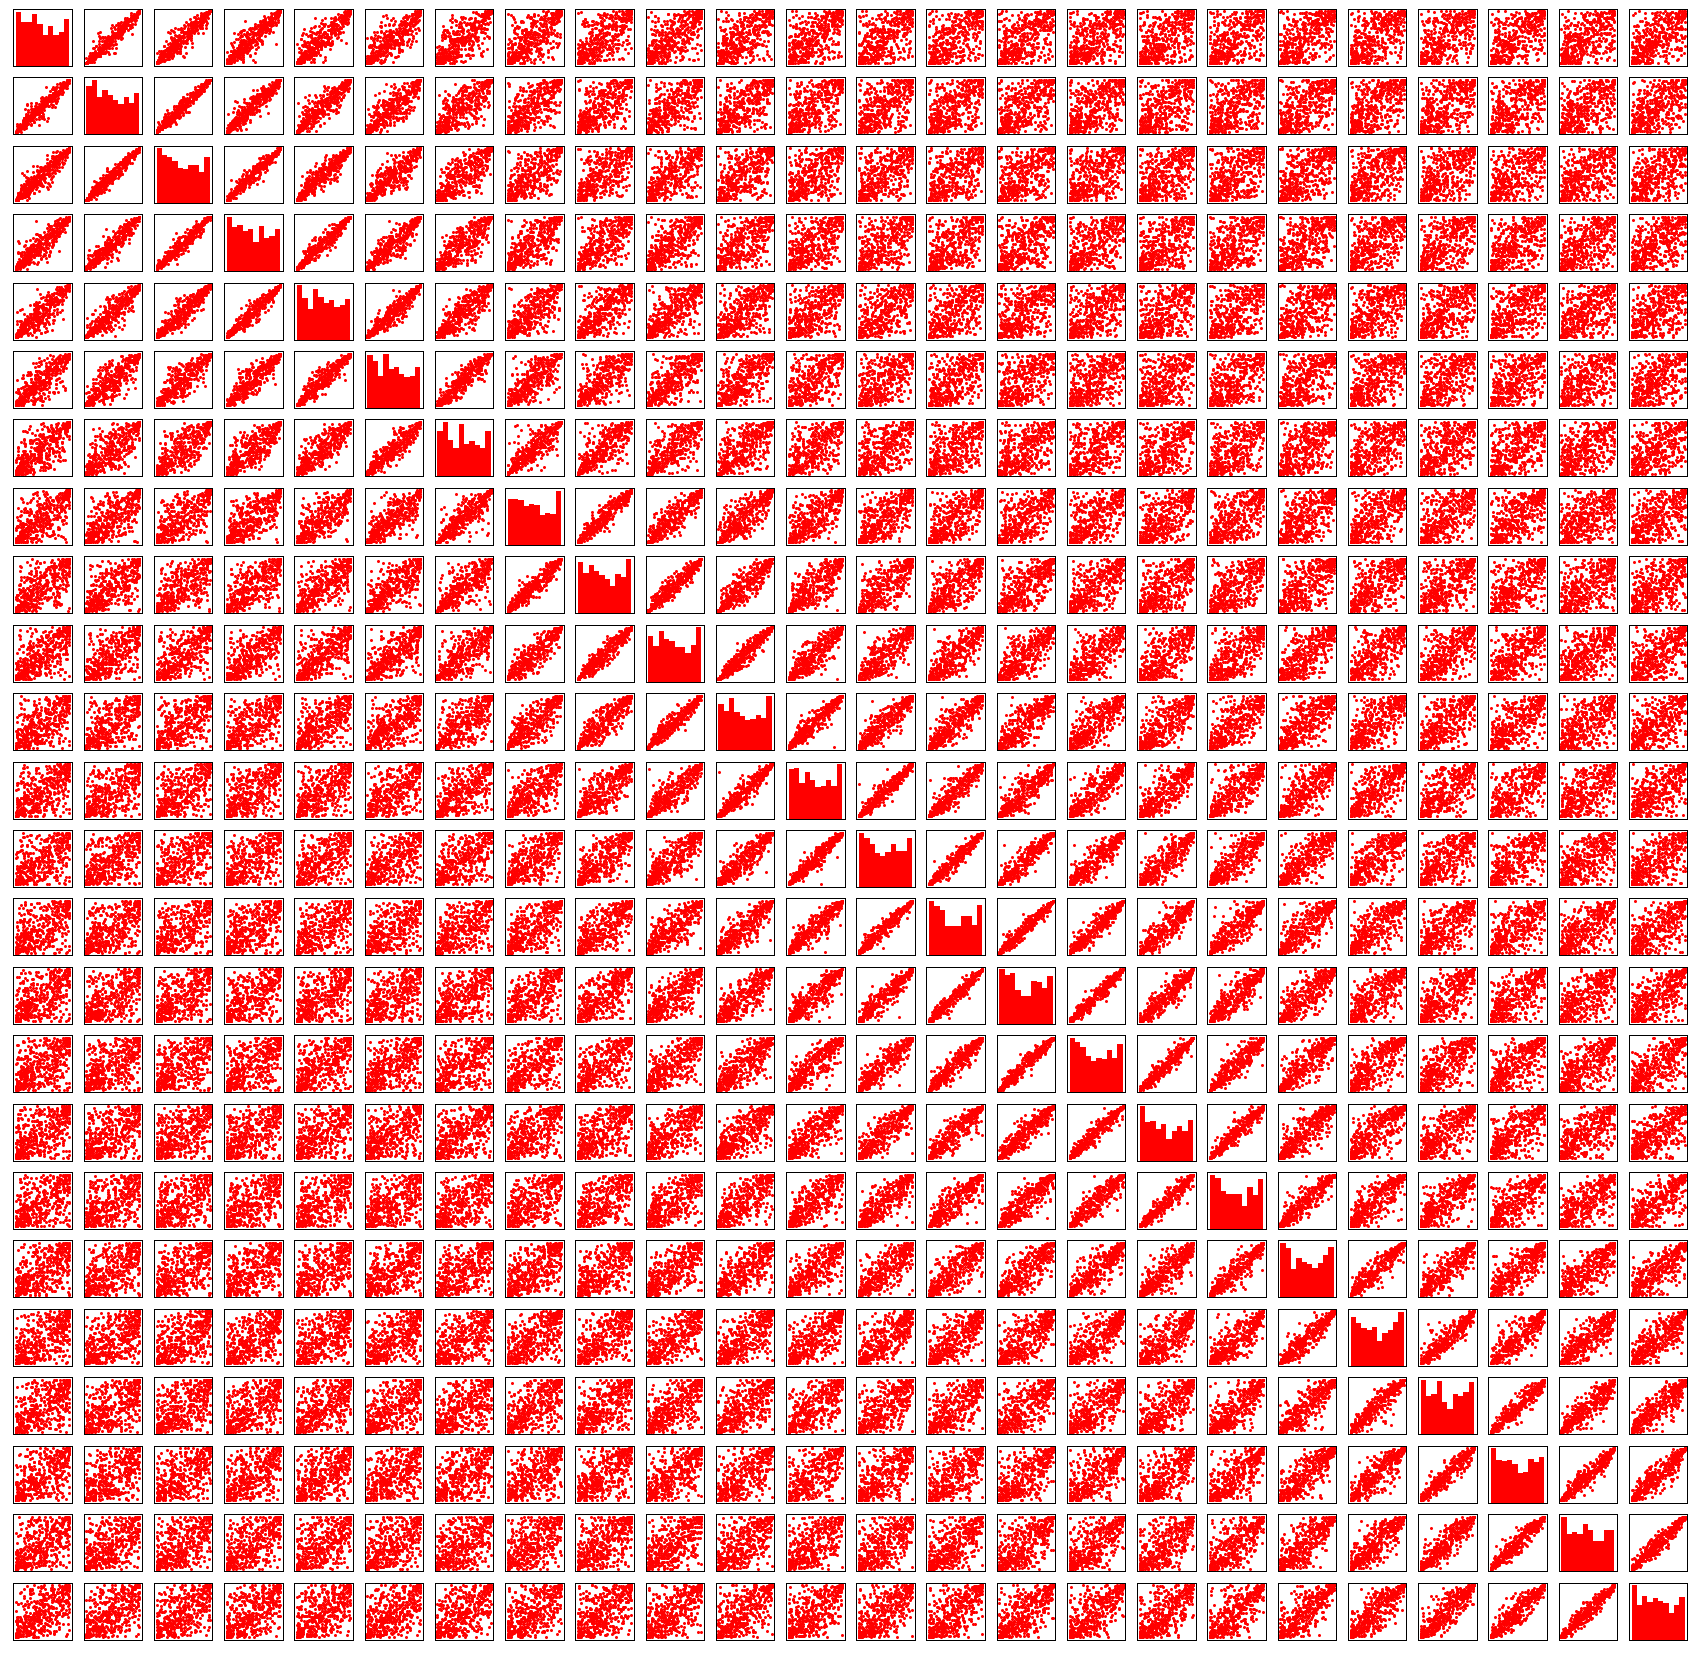

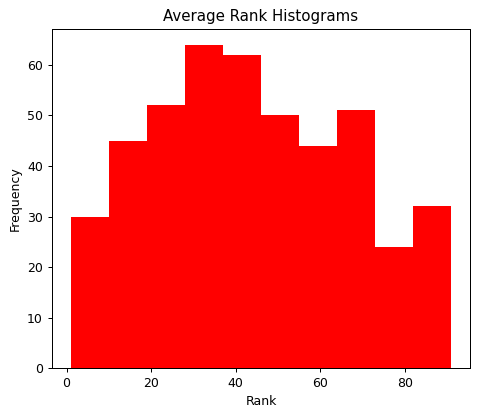

In [67]:
forcast,y_true,crps,es,figs = multivariate_probabilistic_forcast(data=df,start="2021-01-01",end="2022-04-01",
                                                                 ELP='naive',show=True)

从概率预测的分布中获得预测区间

In [77]:
forcast_max = np.max(forcast,axis=0)
forcast_min = np.min(forcast,axis=0)

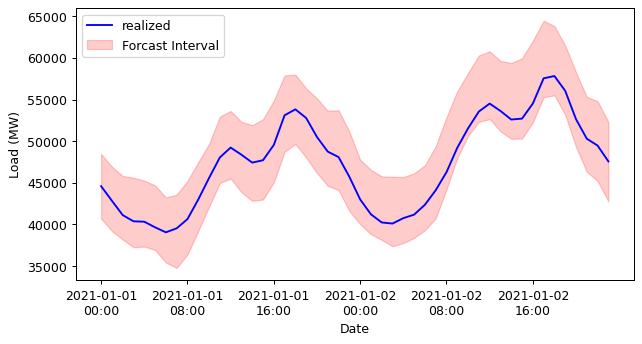

In [120]:
fig = plt.figure(figsize=(8,4),dpi=90)
plt.fill_between(range(48),forcast_min[0:2,:].flatten(),forcast_max[0:2,:].flatten(),color='red',alpha=0.20,label="Forcast Interval")
plt.plot(range(48),y_true[0:2,:].flatten(),color='blue',label="realized")
plt.ylabel("Load (MW)")
plt.xlabel("Date")
plt.xticks(ticks=range(0,48,8),labels=["%s\n%s"%(str(t)[0:10],str(t)[11:16]) for t in df.iloc[52464:52464+48,0][::8]])
plt.legend(loc="upper left")